### Housekeeping

In [249]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tabulate import tabulate
from IPython.display import Latex
import tikzplotlib
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from colorspacious import cspace_converter

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Lasso, LassoCV 
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import LogisticRegression, ElasticNetCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder


import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline


import seaborn as sns

## Data from FRED
#### FRED API Key
'/Users/joanne/Desktop/ECON1680/Project1/fred_apikey.txt'
'31f9bf2f6db8c5f4693e171619a73623'

In [77]:
#set up full fred
from full_fred.fred import Fred
apiKey = '/Users/joanne/Desktop/ECON1680/Project1/fred_apikey.txt'
fred = Fred(apiKey)
fred.get_api_key_file()


'/Users/joanne/Desktop/ECON1680/Project1/fred_apikey.txt'

In [78]:
#save FRED ticker names for real GDP, unemployment rate, and spread between 10 year and 2 year treasury
rGDP = 'GDPC1'
une = 'UNRATE'
yieldInv = 'T10Y2Y'

#CSCICP03USM665S consumer confidence normalized at 100


In [107]:
#get some data from FRED
dfGdp = fred.get_series_df(rGDP)
dfUne = fred.get_series_df(une)
dfyield = fred.get_series_df(yieldInv)

In [108]:
# make quarterly data from start date to end date
def clean(df,keep_cols,name,startDate,endDate):
    
    #keep only certain columns
    existing_cols = [col for col in keep_cols if col in df.columns]
    if existing_cols:
        df = df.loc[:, existing_cols]
    
    #convert index datetime
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    
    #select date range
    df = df.loc[startDate:endDate]
    
    #backfill all empties & make sure that df['value'] is numeric
    df = df.replace('.',np.nan)
    df = df.fillna(method = 'backfill')
    df['value'] = pd.to_numeric(df['value'], downcast = 'float')
    
    #create year year variable
    df['Year'] = pd.PeriodIndex(df.index, freq='Y').to_timestamp()
    
    #group by quarter variable
    df = df.groupby(by = ['Year']).mean()
    
    #rename 'value' to something more descriptive
    df = df.rename(columns = {'value':name})
    
    return df

#run functions to reorganize dataframes
cNames = ['date','value']
cleanDfGdp = clean(dfGdp,cNames,'Growth','2005-01-01','2021-12-31')
cleanDfUne = clean(dfUne,cNames,'Unemployment','2006-01-01','2021-12-31')
cleanDfYield = clean(dfyield,cNames,'10y2yspread','2006-01-01','2021-12-31')

In [109]:
#conver GDP into yearly growth
cleanDfGdp = cleanDfGdp.pct_change()*100
cleanDfGdp = cleanDfGdp.dropna()
cleanDfGdp

,Growth
Year,
2006-01-01,2.782810
2007-01-01,2.010512
2008-01-01,0.122190
2009-01-01,-2.599889
2010-01-01,2.708852
2011-01-01,1.549900
2012-01-01,2.280688
2013-01-01,1.841879
2014-01-01,2.287769


In [110]:
#aggregate all fred data of interest
dfFred = cleanDfGdp.join(cleanDfUne)
dfFred = dfFred.join(cleanDfYield)



In [114]:
dfA = dfFred.copy()
dfA.index = dfA.index.year
print(dfA.index)

Int64Index([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
            2017, 2018, 2019, 2020, 2021],
           dtype='int64', name='Year')


In [116]:
dfFred = dfA.copy()
dfFred.head()

,Growth,Unemployment,10y2yspread
Year,,,
2006,2.782810,4.608333,-0.023654
2007,2.010512,4.616667,0.272567
2008,0.122190,5.800000,1.653702
2009,-2.599889,9.283333,2.304253
2010,2.708852,9.608334,2.510077


In [140]:
FredGrowth_codes = dfFred['Growth'].to_dict()
FredUnrate_codes = dfFred['Unemployment'].to_dict()
FredYield_codes = dfFred['10y2yspread'].to_dict()

In [151]:
key = list(FredGrowth_codes.keys())[0]
type(key)

int

In [30]:
#Dummy variables
dfFredDum = pd.DataFrame(index = dfFred.index)

#For all columns in dfFred
dfFredDum['Growth Dummy'] = (dfFred['Growth'] < 0).astype(int)
dfFredDum['Unemployment Dummy'] = (dfFred['Unemployment'] > 5).astype(int)
dfFredDum['10y2yspread Dummy'] = (dfFred['10y2yspread'] < 0).astype(int)



In [31]:
# Create the 'R' dummy variable, indicating recession
dfFredDum['R'] = ((dfFredDum['Growth Dummy'] != 0) | 
                  (dfFredDum['Unemployment Dummy'] != 0) | 
                  (dfFredDum['10y2yspread Dummy'] != 0)).astype(int)

dfFredDum

,Growth Dummy,Unemployment Dummy,10y2yspread Dummy,R
Year,,,,
2006-01-01,0,0,1,1
2007-01-01,0,0,0,0
2008-01-01,0,1,0,1
2009-01-01,1,1,0,1
2010-01-01,0,1,0,1
2011-01-01,0,1,0,1
2012-01-01,0,1,0,1
2013-01-01,0,1,0,1
2014-01-01,0,1,0,1


In [32]:
dfRecession = pd.DataFrame(index = dfFred.index)
dfRecession = dfRecession.join(dfFred['Growth'])
dfRecession = dfRecession.join(dfFredDum['Growth Dummy'])
dfRecession = dfRecession.join(dfFredDum['R'])                                
dfRecession

,Growth,Growth Dummy,R
Year,,,
2006-01-01,2.782810,0,1
2007-01-01,2.010512,0,0
2008-01-01,0.122190,0,1
2009-01-01,-2.599889,1,1
2010-01-01,2.708852,0,1
2011-01-01,1.549900,0,1
2012-01-01,2.280688,0,1
2013-01-01,1.841879,0,1
2014-01-01,2.287769,0,1


## IPUMS Data

**Housing data from ACS via IPUMS**

Data has been split into two groups: owned and rented.

#define
fPath = '/Users/joanne/Desktop/ECON1680/Project1'

#opening data for households owning home & renting
dfOwn = pd.read_csv(os.path.join(fPath,"ipumsOwn.csv"), encoding='unicode_escape')
dfRent = pd.read_csv(os.path.join(fPath,"ipumsRent.csv"), encoding='unicode_escape')

#summarize owning households
dfOwn.describe()

#summarize renting households
dfRent.describe()

In [3]:
dfOwn= dfOwn[dfOwn['ROOMS'] != 0]
dfOwn= dfOwn[dfOwn['BEDROOMS'] != 0]
dfOwn.loc[dfOwn['BEDROOMS'] != 1, 'BEDROOMS'] -= 1

In [4]:
dfRent= dfRent[dfRent['ROOMS'] != 0]
dfRent= dfRent[dfRent['BEDROOMS'] != 0]
dfRent.loc[dfRent['BEDROOMS'] != 1, 'BEDROOMS'] -= 1

#double checking we have the right years from FRED
print(dfRent['YEAR'].unique())

#list column names to avoid typos
print('Variable names for dfOwn')
print(list(dfOwn))
print('Variable names for dfRent')
print(list(dfRent))

#select specific columns to reduce computational speed

dfOwnSelect = dfOwn[['YEAR','NUMPREC', 'HHWT', 'HHTYPE', 'OWNCOST', 'ROOMS', 'BUILTYR2', 'UNITSSTR', 'BEDROOMS']]
print(list(dfOwnSelect))

dfRentSelect = dfRent[['YEAR', 'NUMPREC', 'HHWT', 'HHTYPE', 'RENTGRS', 'ROOMS', 'BUILTYR2', 'UNITSSTR', 'BEDROOMS']]
print(list(dfRentSelect))

#Rows for owned
print(dfOwnSelect.shape[0])

#Rows for rented (commented out code double checks that there are no 0 values (indicating unit is not rented))
#dfRentSelect.drop(dfRentSelect.loc[dfRentSelect['RENTGRS']==0].index, inplace=True)
print(dfRentSelect.shape[0])

### Save df because data is big

dfRentSelect.to_csv(''.join([fPath,'/dfRentSelect.csv']))

dfOwnSelect.to_csv(''.join([fPath,'/dfOwnSelect.csv']))

## New checkpoint - run to skip above IPUMS section


#housekeeping

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Lasso, LassoCV 
from sklearn.linear_model import Ridge, RidgeCV 
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

#define
fPath = '/Users/joanne/Desktop/ECON1680/Project1/'

#opening data for households owning home & renting
dfOwnSelect = pd.read_csv(os.path.join(fPath,"dfOwnSelect.csv"), encoding='unicode_escape')
dfRentSelect = pd.read_csv(os.path.join(fPath,"dfRentSelect.csv"), encoding='unicode_escape')

dfOwnSelect.head()

dfRentSelect.head()

## Alternative

In [ ]:
#list column names to avoid typos
print('Variable names for dfOwn')
print(list(dfOwn))
print('Variable names for dfRent')
print(list(dfRent))

In [5]:
chooseList = ['YEAR','NUMPREC','HHWT','HHTYPE','OWNCOST','BEDROOMS','ROOMS','BUILTYR2']
dfOwn_s = dfOwn[chooseList]
chooseList = ['YEAR','NUMPREC','HHWT','HHTYPE','RENTGRS','BEDROOMS','ROOMS','BUILTYR2']
dfRent_s = dfRent[chooseList]

### Create some new columns for cost of dwelling/rooms
1a) $O_b$ = owncost/bedrooms

1b) $O_r$ = owncost/rooms

2a) $R_b$ = rentgrs/bedrooms

2b) $O_r$ = rentgrs/rooms

indexOwn = dfOwn_s.copy()
indexOwn['BEDROOMS'] = dfOwn_s['OWNCOST'] / dfOwn_s['BEDROOMS']
#indexOwnBed[['UNITSSTR','HHSIZE','BEDROOMS','YEAR']] = dfOwnSelect[['UNITSSTR','NUMPREC','BEDROOMS','YEAR']]
indexOwn['ROOMS'] = dfOwn_s['OWNCOST'] / dfOwn_s['ROOMS']
indexOwn['OWNCOST'] = indexOwn['BEDROOMS'] - indexOwn['ROOMS']
#indexOwnRoom[['UNITSSTR','BUILTYR']] = dfOwn_s[['UNITSSTR','BUILTYR2']]

indexOwn.head()

indexOwn.to_csv(''.join([fPath,'/indexOwn.csv']))

indexRentBed = pd.DataFrame(index=dfRentSelect.index)
#indexRentBed['O_b'] = dfRentSelect['RENTGRS'] / dfRentSelect['BEDROOMS']
indexRentBed[['UNITSSTR','BUILTYR','YEAR','NUMPREC', 'HHWT','RENTGRS']] = dfRentSelect[['UNITSSTR','BUILTYR2','YEAR','NUMPREC', 'HHWT','RENTGRS']]

df = indexRentBed.copy()
df = df.drop('HHWT', axis=1).mul(df['HHWT'], axis=0)
#indexRentBed = indexRentBed.drop(df['HHWT'], axis=1)
df.head()



# Alt 2 - Start Here

In [2]:
fPath = '/Users/joanne/Desktop/ECON1680/Project1'

#opening data for households owning home & renting
dfOwn = pd.read_csv(os.path.join(fPath,"indexOwn.csv"), encoding='unicode_escape')

print(indexOwn.shape[0])
indexOwn.describe()

In [3]:
#Function to reduce data size
#Random State 42
def reduce(df, size, col):
    X = df.drop(col, axis=1).copy()
    y = df[col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size,random_state=42)
    dfTest = X_test.join(y_test)
    return dfTest


In [9]:
dfSample = reduce(dfOwn, 0.01, 'YEAR')

In [38]:
dfSample = dfSample.drop('Unnamed: 0',axis=1)

In [39]:
dfSample.head()

,NUMPREC,HHWT,HHTYPE,OWNCOST,BEDROOMS,ROOMS,BUILTYR2,YEAR
14681379,4,168.0,1,145.000000,435.000000,290.000000,6,2012
18399181,3,37.0,5,116.666667,233.333333,116.666667,11,2014
27243436,3,92.0,3,62.533333,156.333333,93.800000,6,2018
20121020,2,315.0,1,52.777778,95.000000,42.222222,4,2015
20261881,4,119.0,1,95.666667,287.000000,191.333333,6,2015


In [40]:
sample_codes = {
    'NUMPREC': 'HHSIZE',
    'HHWT': 'HHWT',
    'HHTYPE': 'HHTYPE',
    'OWNCOST': 'Spread',
    'BEDROOMS': 'Cost/Bed',
    'ROOMS': 'Cost/Rooms',
    'BUILTYR2': 'BUILTYEAR',
}


In [169]:
df = dfSample.copy()
filtered_codes = {k: v for k, v in sample_codes.items() if k in df.columns}
df.rename(columns=filtered_codes, inplace=True)


In [170]:
df['Growth'] = df['YEAR'].map(FredGrowth_codes)
df['Unrate'] = df['YEAR'].map(FredUnrate_codes)
df['Yield'] = df['YEAR'].map(FredYield_codes)

df = df.drop('YEAR',axis=1)

In [171]:
df.head()

,HHSIZE,HHWT,HHTYPE,Spread,Cost/Bed,Cost/Rooms,BUILTYEAR,Growth,Unrate,Yield
14681379,4,168.0,1,145.000000,435.000000,290.000000,6,2.280688,8.075000,1.525709
18399181,3,37.0,5,116.666667,233.333333,116.666667,11,2.287769,6.158333,2.077165
27243436,3,92.0,3,62.533333,156.333333,93.800000,6,2.945375,3.891667,0.382912
20121020,2,315.0,1,52.777778,95.000000,42.222222,4,2.706373,5.275000,1.450268
20261881,4,119.0,1,95.666667,287.000000,191.333333,6,2.706373,5.275000,1.450268


## Clustering


### Data too big. try kmeans
def clusterPlot(df):
    
    colNames = list(df)
    print(colNames)
    #df = pd.DataFrame(normalize(df),columns=colNames)
    
    Clustering = AgglomerativeClustering(n_clusters = 2,affinity='euclidean',linkage='ward')
    Clustering.fit(df)
    
    k = 'CLUSTER'
    df[k] = Clustering.labels_
    
    principalComponents = PCA(n_components = 2).fit_transform(df)
    dfNew = pd.DataFrame(principalComponents, columns = ['PC1','PC2'])
    
    #plt.scatter(dfNew['PC1'],dfNew['PC2'])
    scatterMult(df,k)


In [266]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import colorspacious as cspace


# Create a diverging colormap using the coolwarm colorspace
# coolwarm = cspace.cspace_converter("sRGB1", "CAM02-UCS")(plt.cm.coolwarm(np.linspace(0, 1, 256)))

# Create a discrete colormap with a unique color for each group
# cmap = ListedColormap(plt.cm.coolwarm(np.linspace(0, 1, num_groups)))

#Scatter all arrangements & save
def scatterMult(df, k, num_groups, fPath, fName):
    # Initialize a PDF file to save the plots
    with PdfPages(fPath + '/' + fName + '.pdf') as pdf:
        # Plot each pair of columns
        for i, col1 in enumerate(df.columns[:-1]):
            for j, col2 in enumerate(df.columns[i+1:-1]):
                plt.scatter(df[col1], df[col2], c=df[k])
                plt.xlabel(col1)
                plt.ylabel(col2)
                # Get the TikZ code as a string
                tikz_code = tikzplotlib.get_tikz_code()
                # Print the TikZ code
                print(tikz_code)
                plt.show()
    print(fPath + '/' + fName + '.pdf')



In [265]:
#Scatter all arrangements & save
def scatterMult(df, k, num_groups, fPath, fName):
    # Define a discrete colormap with a unique color for each group
    cmap = ListedColormap(['C{}'.format(i) for i in range(num_groups)])

    # Initialize a PDF file to save the plots
    with PdfPages(fPath + '/' + fName + '.pdf') as pdf:
        # Plot each pair of columns
        for i, col1 in enumerate(df.columns[:-1]):
            for j, col2 in enumerate(df.columns[i+1:-1]):
                plt.scatter(df[col1], df[col2], c=df[k], cmap=cmap)
                plt.xlabel(col1)
                plt.ylabel(col2)
                # Get the TikZ code as a string
                tikz_code = tikzplotlib.get_tikz_code(float_format='.0f')
                # Print the TikZ code
                print(tikz_code)
                plt.show()
    print(fPath + '/' + fName + '.pdf')


### K-Means

In [210]:
#detect multicolinearity for a dataframe
def detectMulti(df2):
    
    df = df2.dropna(how='any')
    
    # Check for missing values
    if df.isnull().sum().sum() > 0:
        print('Warning: Missing values found in the dataset. Please handle missing values before detecting multicollinearity.')
    
    # Identify the numerical columns
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    
    # Calculate the correlation matrix for the numerical columns
    corr_matrix = df[num_cols].corr()
    
    # Visualize the correlation matrix using a heatmap
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt='.2f', square=True)
    plt.title('Correlation Matrix')
    plt.show()
    
    # Check for columns with high correlation
    threshold = 0.8 # define the threshold for high correlation
    corr_matrix = corr_matrix.abs() # convert all values to absolute values
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) # select upper triangle of correlation matrix
    collinear_cols = [column for column in upper.columns if any(upper[column] > threshold)] # identify columns with high correlation
    
    if len(collinear_cols) == 0:
        print('No columns with high correlation found.')
    else:
        print('Columns with high correlation:', collinear_cols)
    
    return collinear_cols


In [19]:
def normDf(df):
    df_norm = pd.DataFrame(normalize(df), columns = df.columns, index=df.index)
    return df_norm

In [232]:
#kmeans on all axis with changable number of clusters
def weighted_kmeans(df, numClus, fPath, fName):
    # Scale the data
    scaler = StandardScaler()
    X = scaler.fit_transform(df.drop('HHWT', axis=1))

    # Cluster using weighted k-means
    kClustering = KMeans(n_clusters=numClus, algorithm='full')
    kClustering.fit(X, sample_weight=df['HHWT'])

    # Assign cluster labels to each data point
    df['KMLABEL'] = kClustering.labels_
    
    #plot
    scatterMult(df, 'KMLABEL', numClus, fPath, fName)

In [74]:


#visualize kmeans on two axis
def kmeanPCA(df):
    
    print(list(df))
    #normalize
    df = normDf(df)
    df = df.dropna()
    pca = PCA(n_components=2)
    pca.fit(df)
    
    #Print PCA
    components = pd.DataFrame(pca.components_, columns=df.columns)
    explained_variance_ratio = pca.explained_variance_ratio_
    
    data_pca = pca.transform(df)
    
    var_list1 = data_pca[:, 0] # variance captured by PCA1
    var_list2 = data_pca[:, 1] # variance captured by PCA2
    var_list3 = data_pca[:, :2].sum(axis=1) # variance captured by both PCA1 and PCA2
    var_list4 = data_pca[:, :2].prod(axis=1) # variance captured by the interaction of PCA1 and PCA2

    # create four lists that only capture variance of PCA1
    pca1_var_list1 = data_pca[:, 0] # variance captured by PCA1
    pca1_var_list2 = np.zeros_like(var_list2) # zero list to represent no variance captured by PCA2
    pca1_var_list3 = data_pca[:, 0] # variance captured by PCA1
    pca1_var_list4 = np.zeros_like(var_list4) # zero list to represent no interaction between PCA1 and PCA2
    
    dfNew = pd.DataFrame(pca, columns = ['PC1','PC2'])
    
    print("Four unique lists to capture variance of the dataset:")
    print(var_list1)
    print(var_list2)
    print(var_list3)
    print(var_list4)

    print("Four lists that only capture variance of PCA1:")
    print(pca1_var_list1)
    print(pca1_var_list2)
    print(pca1_var_list3)
    print(pca1_var_list4)

    #cluster
    kClustering = KMeans(n_clusters=8)
    kClustering.fit(df)
    
    k = 'KMLABEL'
    labels = kClustering.labels_
    df.loc[:, k] = labels
    
    print("Explained Variance Ratio:")
    print(explained_variance_ratio)
    print(pca.components_)
    print(tabulate(components, headers='keys', tablefmt='latex_booktabs'))

    plt.scatter(dfNew['PC1'],dfNew['PC2'])
    plt.show()

In [51]:
print(list(df))

['HHSIZE', 'HHWT', 'HHTYPE', 'Spread', 'Cost/Bed', 'Cost/Rooms', 'BUILTYEAR', 'YEAR']


In [205]:
print(list(df))

['HHSIZE', 'HHWT', 'HHTYPE', 'Spread', 'Cost/Bed', 'Cost/Rooms', 'BUILTYEAR', 'Growth', 'Unrate', 'Yield']


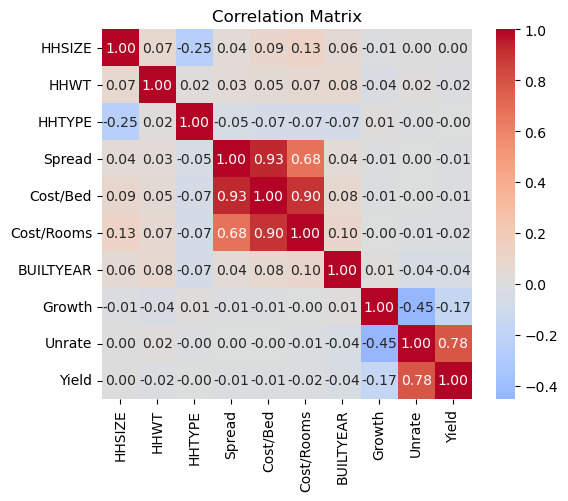

Columns with high correlation: ['Cost/Bed', 'Cost/Rooms']


/var/folders/pb/3jsdg1n52l722yxt1jl699pw0000gn/T/ipykernel_1585/1691031316.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) # select upper triangle of correlation matrix


['Cost/Bed', 'Cost/Rooms']

In [154]:
detectMulti(df)

['Spread', 'BUILTYEAR', 'Growth', 'Unrate', 'Yield']


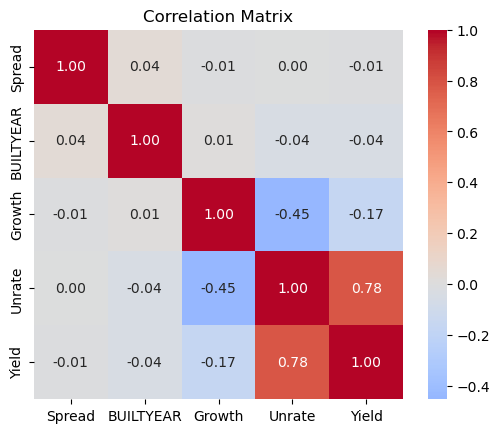

No columns with high correlation found.


/var/folders/pb/3jsdg1n52l722yxt1jl699pw0000gn/T/ipykernel_1585/3304737534.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) # select upper triangle of correlation matrix


[]

In [219]:
dfIPUMS = df.drop(['HHSIZE','HHTYPE','HHWT','Cost/Bed', 'Cost/Rooms'],axis=1).copy()

print(list(dfIPUMS))
detectMulti(dfIPUMS)

['HHSIZE', 'HHWT', 'HHTYPE', 'Spread', 'Cost/Bed', 'Cost/Rooms', 'BUILTYEAR', 'YEAR']


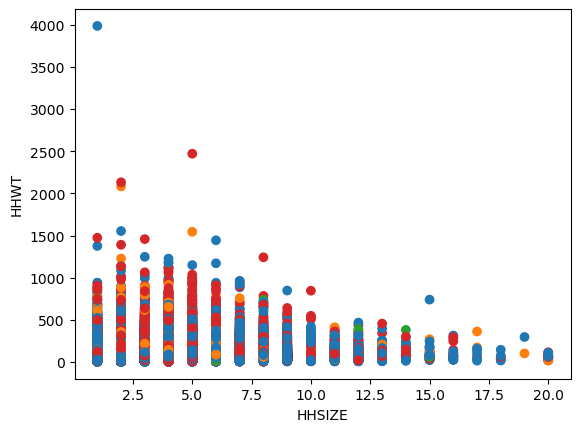

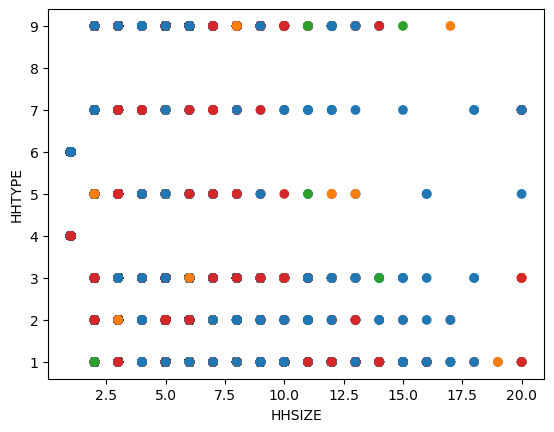

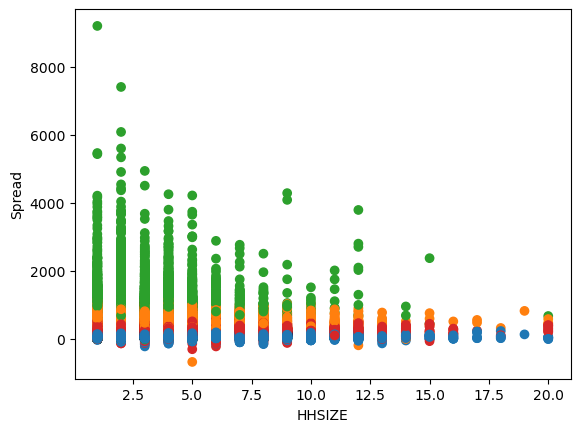

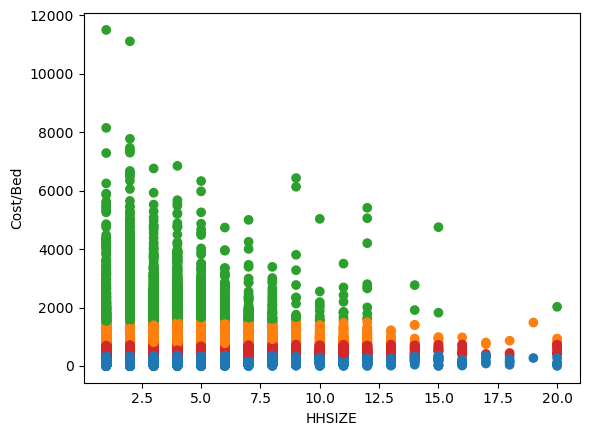

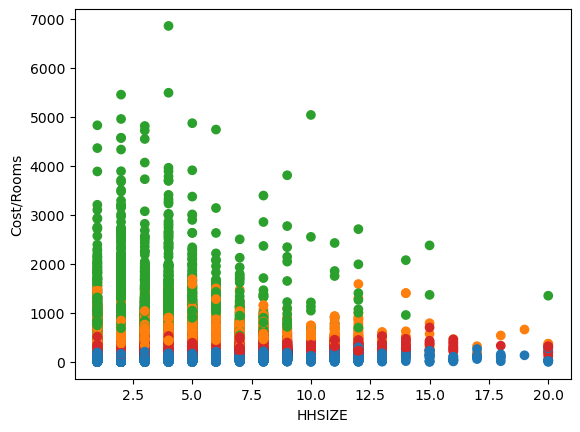

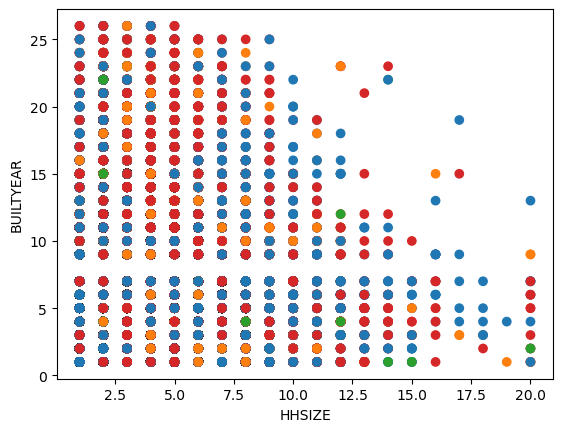

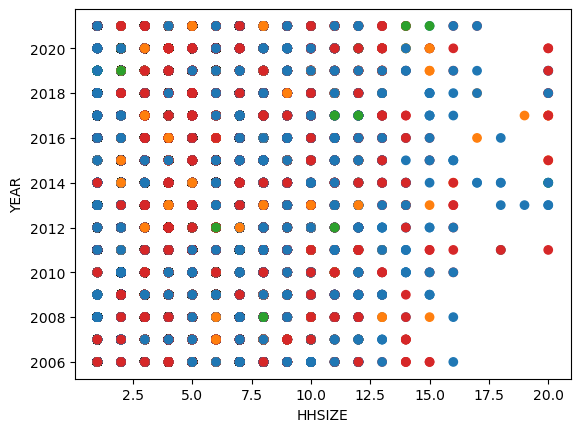

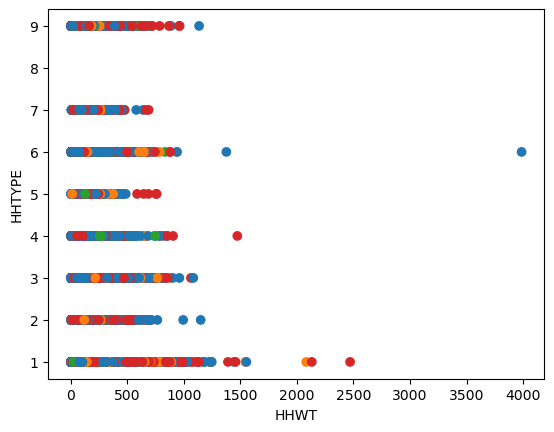

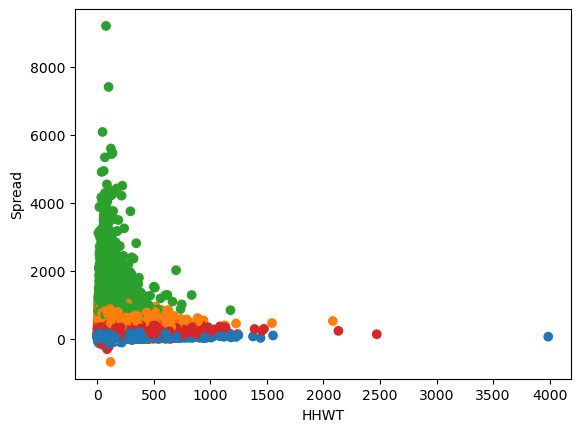

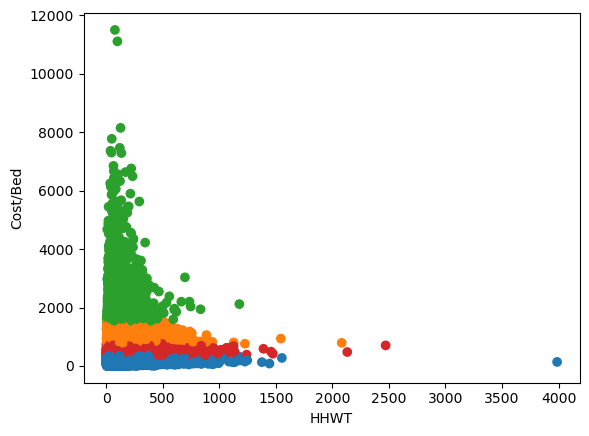

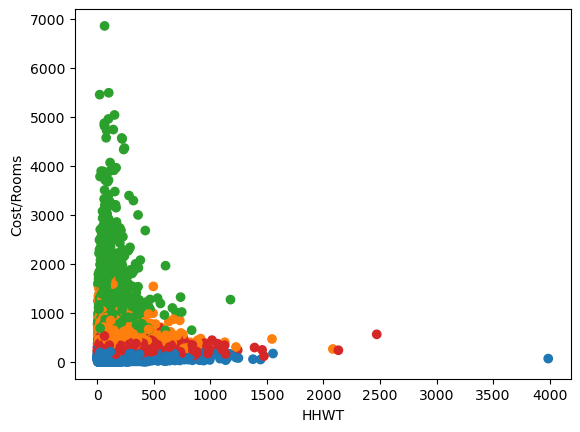

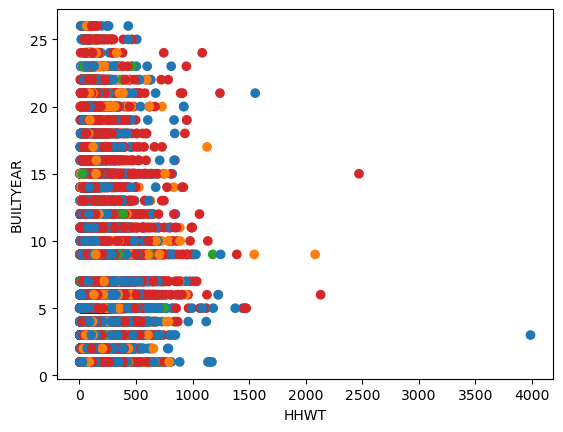

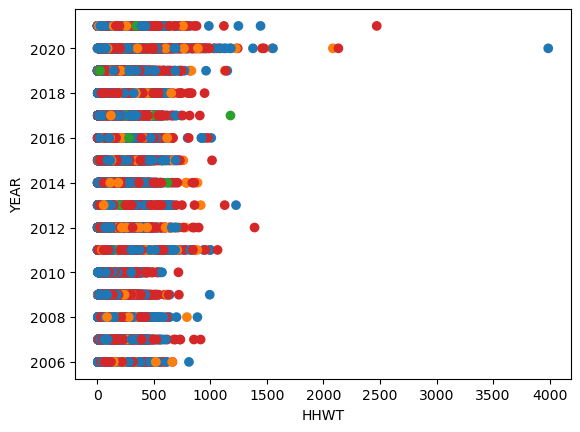

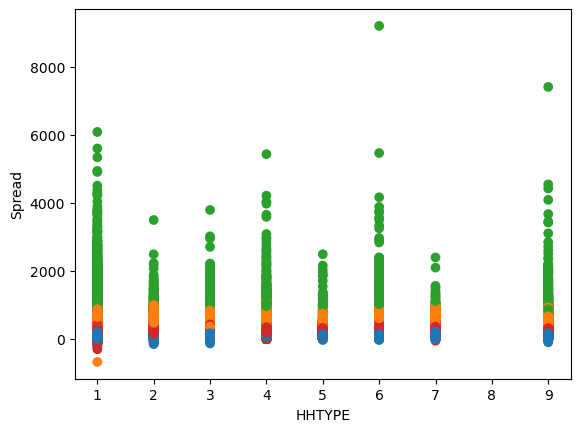

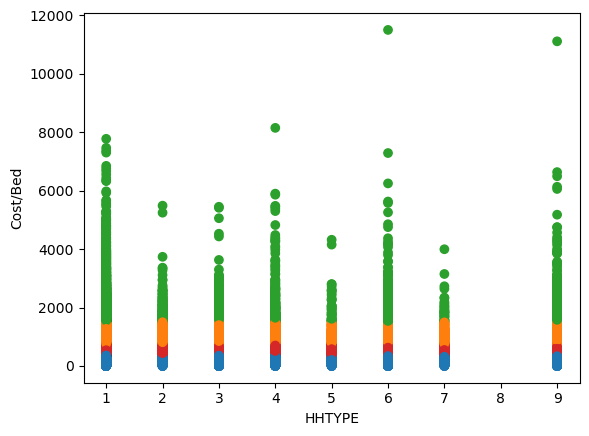

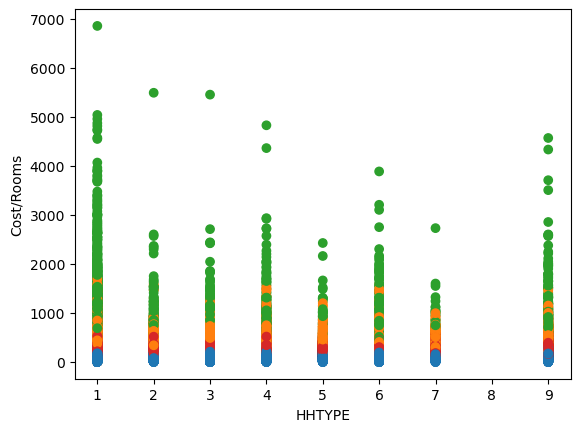

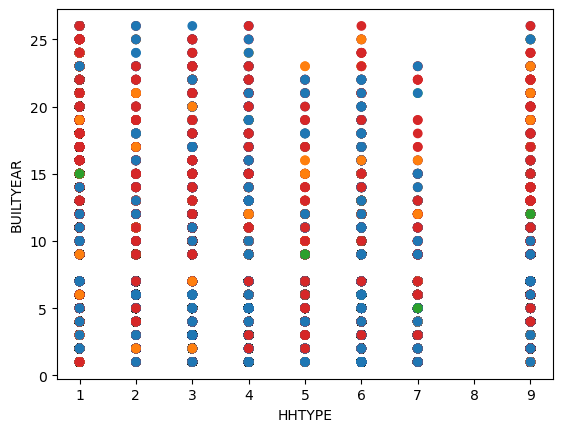

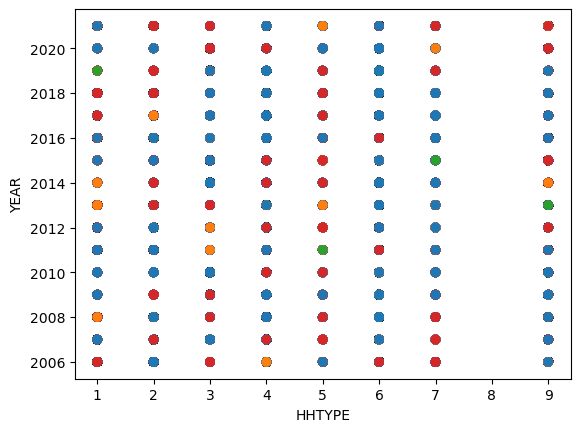

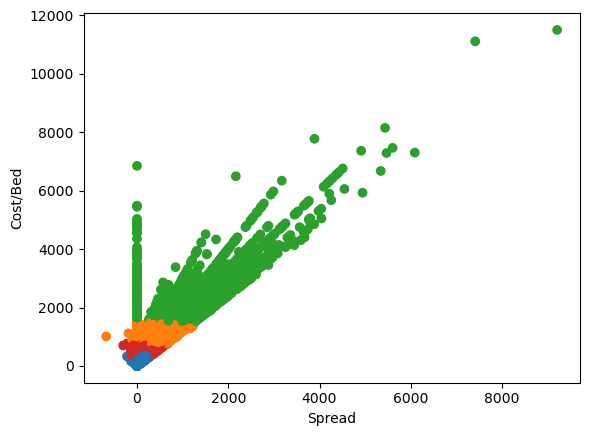

In [ ]:
# Example usage:
fName = 'ipums_kmean4scatters'
kmean(df, 4, fPath, fName) # Assuming the dataset is stored in a variable named 'df'


In [225]:
df.head()

,HHSIZE,HHWT,HHTYPE,Spread,Cost/Bed,Cost/Rooms,BUILTYEAR,Growth,Unrate,Yield
14681379,4,168.0,1,145.000000,435.000000,290.000000,6,2.280688,8.075000,1.525709
18399181,3,37.0,5,116.666667,233.333333,116.666667,11,2.287769,6.158333,2.077165
27243436,3,92.0,3,62.533333,156.333333,93.800000,6,2.945375,3.891667,0.382912
20121020,2,315.0,1,52.777778,95.000000,42.222222,4,2.706373,5.275000,1.450268
20261881,4,119.0,1,95.666667,287.000000,191.333333,6,2.706373,5.275000,1.450268


In [26]:
df = df.drop(NaN,axis=1)

NameError: name 'NaN' is not defined

In [244]:
kmeanPCA(df)

['HHSIZE', 'HHWT', 'HHTYPE', 'Spread', 'Cost/Bed', 'Cost/Rooms', 'BUILTYEAR', 'Growth', 'Unrate', 'Yield']
Four unique lists to capture variance of the dataset:
[ 0.07922985 -0.11063639  0.21103073 ...  0.45711807  0.02545397
 -0.16178672]
[ 0.18199888  0.02072442  0.09110795 ... -0.08748128  0.11790435
  0.10795402]
[ 0.26122873 -0.08991197  0.30213868 ...  0.36963678  0.14335832
 -0.0538327 ]
[ 0.01441974 -0.00229288  0.01922658 ... -0.03998928  0.00300113
 -0.01746553]
Four lists that only capture variance of PCA1:
[ 0.07922985 -0.11063639  0.21103073 ...  0.45711807  0.02545397
 -0.16178672]
[0. 0. 0. ... 0. 0. 0.]
[ 0.07922985 -0.11063639  0.21103073 ...  0.45711807  0.02545397
 -0.16178672]
[0. 0. 0. ... 0. 0. 0.]
Explained Variance Ratio:
[0.7156417  0.24882062]
[[ 1.60978504e-02  8.96135510e-01  1.54113269e-02 -2.47872953e-01
  -3.49753951e-01 -1.01880998e-01  2.89859389e-02  9.69208999e-03
   3.61655871e-02  7.33910604e-03]
 [ 7.19047387e-03 -9.26944390e-02 -4.89887830e-04 -6.

ValueError: DataFrame constructor not properly called!

# Ignore past this point

"""def cluster(df,numClus,graphName):

    cluster = shc.linkage(df.astype(float), method='ward')
    
    fig = plt.figure(figsize=(25, 10))
    dn = shc.dendrogram(cluster.fit(df))
    plt.title(graphName)
    plt.show()

def joinCluster(dfCol,dfBase,graphName,chunkSize):
    for chunk in pd.read_csv(dfBase, chunksize=chunkSize):
        df = chunk.copy()
        df['COSTRATIO'] = dfCol
        df = df.astype('float16')
        cluster(df,graphName)
"""

In [ ]:
df_scaled = normalize(df_clustering) 
df_scaled = pd.DataFrame(df_scaled, columns=df_clustering.columns, index=df_clustering.index)

df_scaled.head()

In [ ]:
#perform hierarchical clustering on df_scaled using ward method
cluster = shc.linkage(df_scaled, method='ward', metric='euclidean', optimal_ordering=False)

#make dendrogram
fig = plt.figure(figsize=(25, 10))
dn = shc.dendrogram(cluster)

#add a title
plt.title("Dendrogram of Countries Along Political Variables")

#add line running through tallest split
plt.axhline(y= 1 + 1, color='red', linestyle='--')

#show plot
plt.show()

## Variable Selection LASSO 

## Regressions
1. OLS
2. LASSO -> OLS
3. LASSO -> LASSO

In [185]:
def splitSet(df, varY, weights):
    y = df[varY]
    X = df.drop(varY, axis=1)
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights,test_size=0.2)
    return X_train, X_test, y_train, y_test, w_train, w_test


In [199]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

def compare_regression_methods(df, varY, wcol, l1_ratio=0.5):
    alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    
    df = df.dropna(how='any')
    
    weights = df[wcol]
    
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(df.drop(varY, axis=1), df[varY], weights, test_size=0.3, random_state=42)
    
    X = X_train
    # Fit the OLS model
    olsReg = LinearRegression()
    olsReg.fit(X_train, y_train)

    # Fit the Lasso, Ridge, and Elastic Net models
    lassoReg = LassoCV(alphas=alphas, cv=5)
    ridgeReg = RidgeCV(alphas=alphas, cv=5)
    elasticReg = ElasticNetCV(alphas=alphas, cv=5, l1_ratio=l1_ratio)

    lassoReg.fit(X_train, y_train, sample_weight=w_train)
    ridgeReg.fit(X_train, y_train, sample_weight=w_train)
    elasticReg.fit(X_train, y_train, sample_weight=w_train)

    # Get the coefficient values and R-squared for each method
    ols_coeffs = olsReg.coef_
    ols_r2 = olsReg.score(X_train, y_train)
    ols_mse = metrics.mean_squared_error(y_train, olsReg.predict(X_train))
    ols_f = (ols_r2/(1-ols_r2))*((X_train.shape[0]-X_train.shape[1]-1)/X_train.shape[1])
    print("OLS R-squared: ", ols_r2)
    print("OLS F-statistic: ", ols_f)
    print("OLS MSE: ", ols_mse)
 
    lasso_coeffs = lassoReg.coef_
    lasso_r2 = lassoReg.score(X_train, y_train)
    lasso_mse = metrics.mean_squared_error(y_train, lassoReg.predict(X_train))
    lasso_f = (lasso_r2/(1-lasso_r2))*((X_train.shape[0]-X_train.shape[1]-1)/X_train.shape[1])
    print("Lasso R-squared: ", lasso_r2)
    print("Lasso F-statistic: ", lasso_f)
    print("Lasso MSE: ", lasso_mse)

    
    ridge_coeffs = ridgeReg.coef_
    ridge_r2 = ridgeReg.score(X_train, y_train)
    ridge_mse = metrics.mean_squared_error(y_train, ridgeReg.predict(X_train))
    ridge_f = (ridge_r2/(1-ridge_r2))*((X_train.shape[0]-X_train.shape[1]-1)/X_train.shape[1])
    print("Ridge R-squared: ", ridge_r2)
    print("Ridge F-statistic: ", ridge_f)
    print("Ridge MSE: ", ridge_mse)
    
    elastic_coeffs = elasticReg.coef_
    elastic_r2 = elasticReg.score(X_train, y_train)
    elastic_mse = metrics.mean_squared_error(y_train, elasticReg.predict(X_train))
    elastic_f = (elastic_r2/(1-elastic_r2))*((X_train.shape[0]-X_train.shape[1]-1)/X_train.shape[1])
    print("Elastic Net R-squared: ", elastic_r2)
    print("Elastic Net F-statistic: ", elastic_f)
    print("Elastic Net MSE: ", elastic_mse)

    
    # Create a dataframe comparing the coefficients and R-squared
    coef_comp = pd.DataFrame({
        'var': X.columns, 
        'var_ols': ols_coeffs, 
        'var_lasso': lasso_coeffs, 
        'var_ridge': ridge_coeffs,
        'var_elastic': elastic_coeffs,
    })
    
    return coef_comp


In [190]:

dfs = df.copy()
dfs.head()

,HHSIZE,HHWT,HHTYPE,Spread,Cost/Bed,Cost/Rooms,BUILTYEAR,Growth,Unrate,Yield
14681379,4,168.0,1,145.000000,435.000000,290.000000,6,2.280688,8.075000,1.525709
18399181,3,37.0,5,116.666667,233.333333,116.666667,11,2.287769,6.158333,2.077165
27243436,3,92.0,3,62.533333,156.333333,93.800000,6,2.945375,3.891667,0.382912
20121020,2,315.0,1,52.777778,95.000000,42.222222,4,2.706373,5.275000,1.450268
20261881,4,119.0,1,95.666667,287.000000,191.333333,6,2.706373,5.275000,1.450268


In [200]:
#dfs = dfs.drop(['HHTYPE'], axis=1)

compare_regression_methods(dfs, 'HHSIZE','HHWT', l1_ratio=0.5)

/Users/joanne/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.90217e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


OLS R-squared:  0.08634826726487677
OLS F-statistic:  2493.734195341812
OLS MSE:  2.589405031564941
Lasso R-squared:  0.08465554665312502
Lasso F-statistic:  2440.32730866024
Lasso MSE:  2.594202416730492
Ridge R-squared:  0.08465613805843442
Ridge F-statistic:  2440.3459335455454
Ridge MSE:  2.5942007406127447
Elastic Net R-squared:  0.08465583274272581
Elastic Net F-statistic:  2440.336318359916
Elastic Net MSE:  2.594201605916234


,var,var_ols,var_lasso,var_ridge,var_elastic
0,HHWT,1.557869e-03,0.000828,0.000829,0.000829
1,HHTYPE,-1.988739e-01,-0.196729,-0.196751,-0.196738
2,Spread,-8.949016e+09,-0.001326,-0.001067,-0.001326
3,Cost/Bed,8.949016e+09,0.000497,0.000238,0.000497
4,Cost/Rooms,-8.949016e+09,0.001075,0.001334,0.001075
5,BUILTYEAR,1.247374e-02,0.012108,0.012115,0.012111
6,Growth,-2.326223e-03,-0.005284,-0.005398,-0.005341
7,Unrate,-5.429553e-03,-0.005610,-0.005889,-0.005748
8,Yield,2.463570e-02,0.017068,0.017688,0.017374


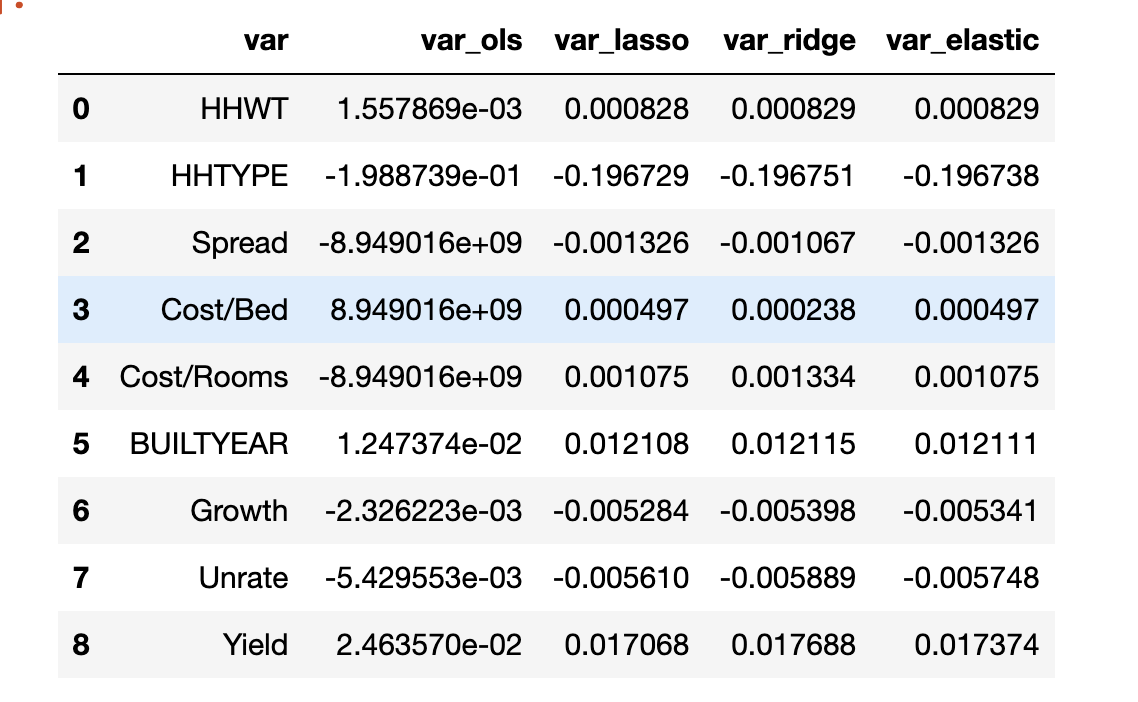
OLS R-squared:  0.08634826726487677
OLS F-statistic:  2493.734195341812
OLS MSE:  2.589405031564941
Lasso R-squared:  0.08465554665312502
Lasso F-statistic:  2440.32730866024
Lasso MSE:  2.594202416730492
Ridge R-squared:  0.08465613805843442
Ridge F-statistic:  2440.3459335455454
Ridge MSE:  2.5942007406127447
Elastic Net R-squared:  0.08465583274272581
Elastic Net F-statistic:  2440.336318359916
Elastic Net MSE:  2.594201605916234

In [228]:
df.head()

,HHSIZE,HHWT,HHTYPE,Spread,Cost/Bed,Cost/Rooms,BUILTYEAR,Growth,Unrate,Yield
14681379,4,168.0,1,145.000000,435.000000,290.000000,6,2.280688,8.075000,1.525709
18399181,3,37.0,5,116.666667,233.333333,116.666667,11,2.287769,6.158333,2.077165
27243436,3,92.0,3,62.533333,156.333333,93.800000,6,2.945375,3.891667,0.382912
20121020,2,315.0,1,52.777778,95.000000,42.222222,4,2.706373,5.275000,1.450268
20261881,4,119.0,1,95.666667,287.000000,191.333333,6,2.706373,5.275000,1.450268


In [229]:
dropList = ['Cost/Rooms','HHTYPE']
dfK = df.drop(dropList,axis=1)
dfK.describe()

,HHSIZE,HHWT,Spread,Cost/Bed,BUILTYEAR,Growth,Unrate,Yield
count,339267.000000,339267.000000,339267.000000,339267.000000,339267.000000,339267.000000,339267.000000,339267.000000
mean,3.292201,91.764422,233.400617,450.569029,5.573666,1.814703,6.209070,1.268082
std,1.682998,70.258896,212.330974,360.225171,3.504538,1.992942,1.947548,0.817962
min,1.000000,1.000000,-674.533333,0.000000,1.000000,-2.767956,3.683333,-0.023654
25%,2.000000,53.000000,97.500000,207.250000,3.000000,1.667476,4.608333,0.382912
50%,3.000000,76.000000,180.138889,371.500000,5.000000,2.280688,5.366667,1.177165
75%,4.000000,108.000000,301.000000,581.500000,7.000000,2.708852,8.075000,2.045364
max,20.000000,3987.000000,9204.800000,11506.000000,26.000000,5.946624,9.608334,2.510077


In [230]:
dfK = normDf(dfK)

['HHSIZE', 'HHWT', 'Spread', 'Cost/Bed', 'BUILTYEAR', 'Growth', 'Unrate', 'Yield', 'KMLABEL']


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



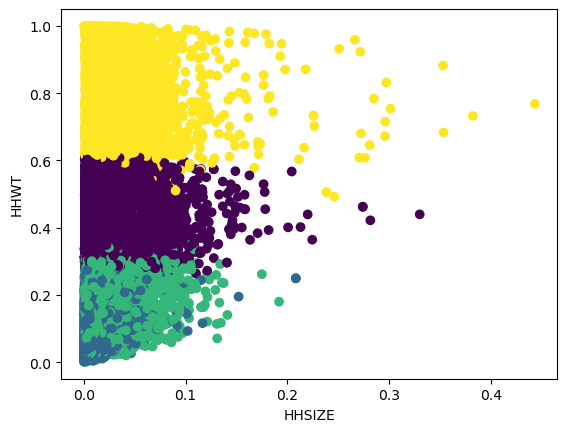

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



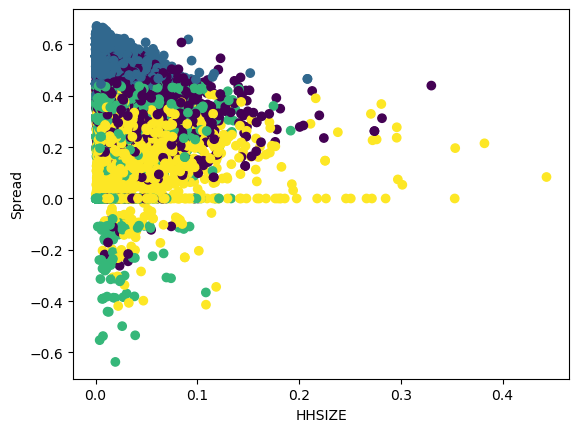

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



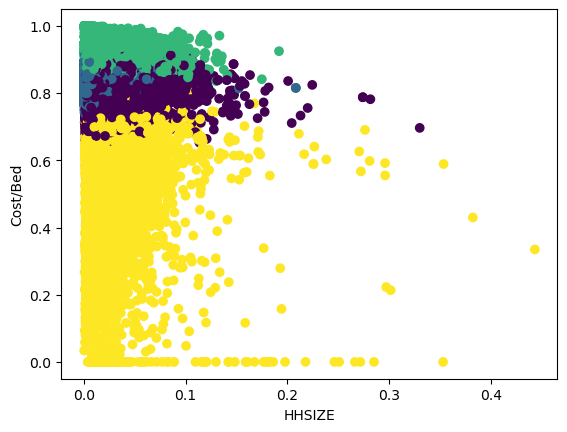

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



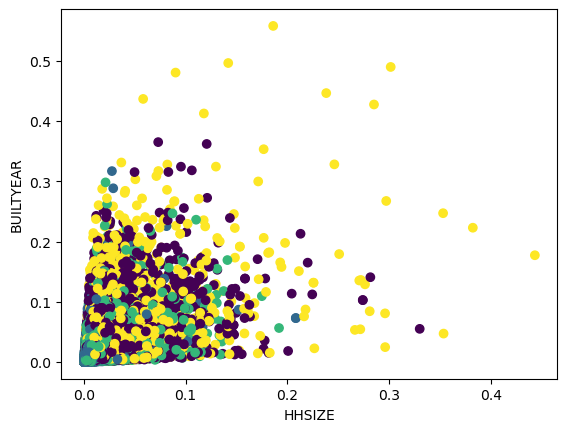

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



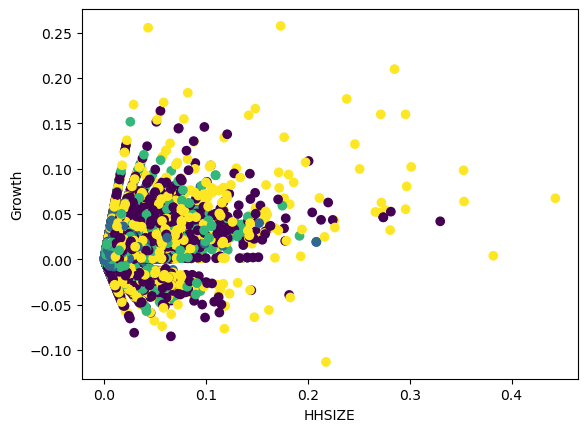

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



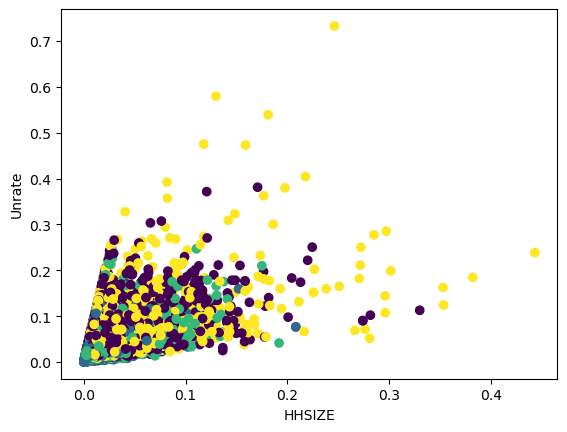

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



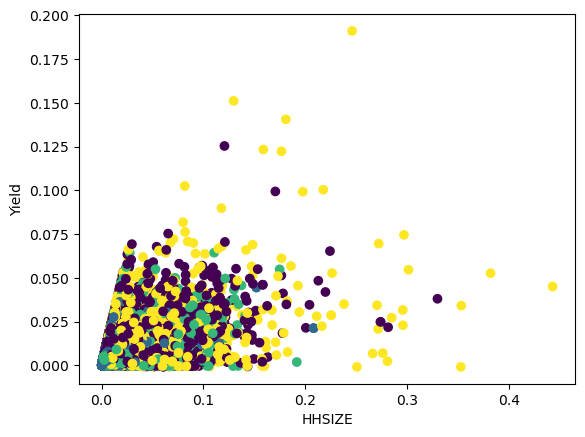

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



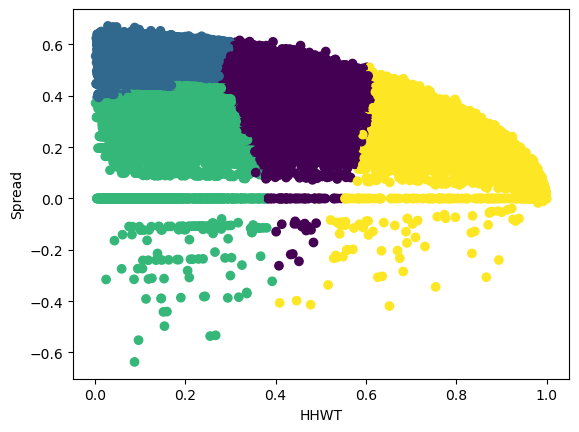

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



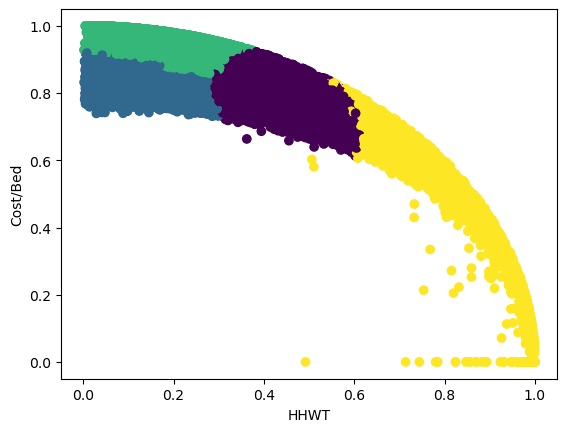

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



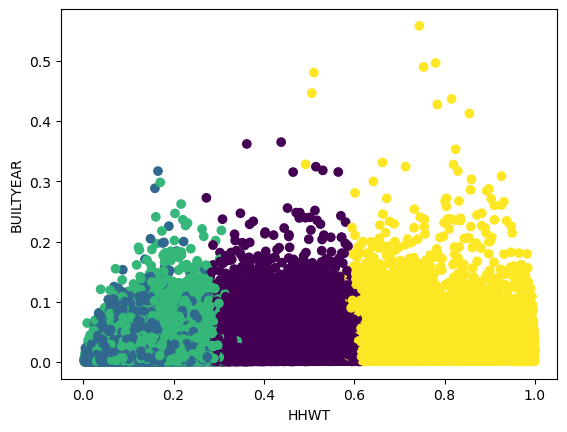

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



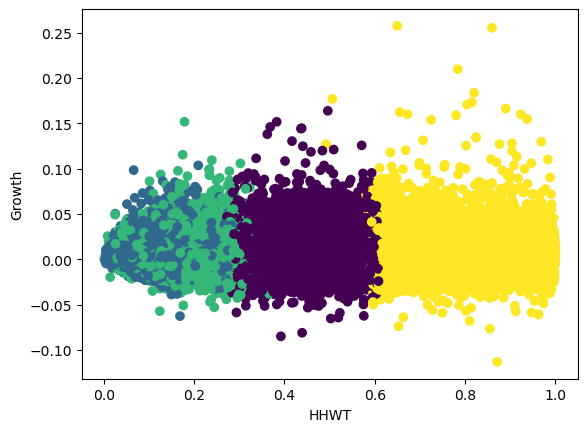

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



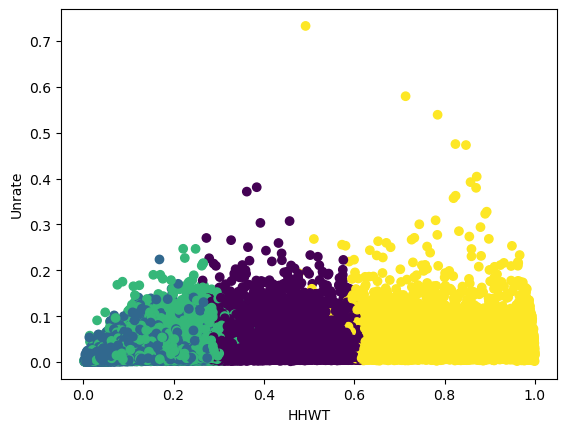

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



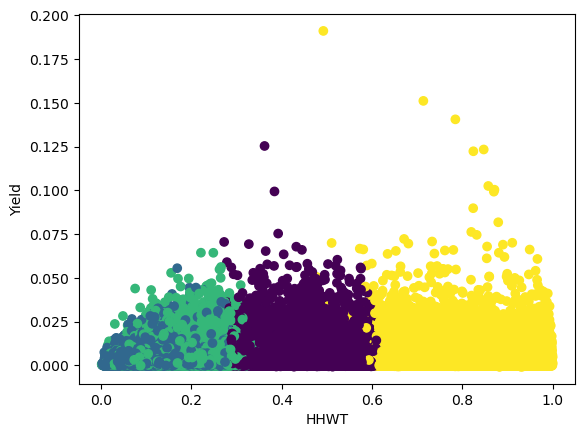

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



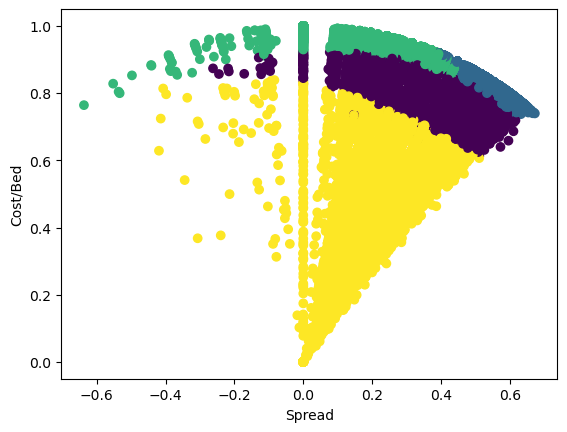

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



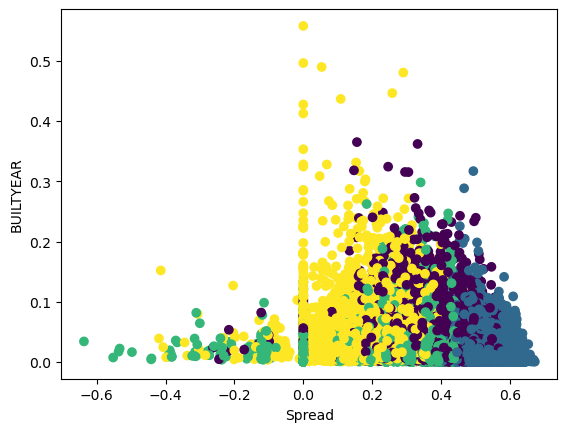

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



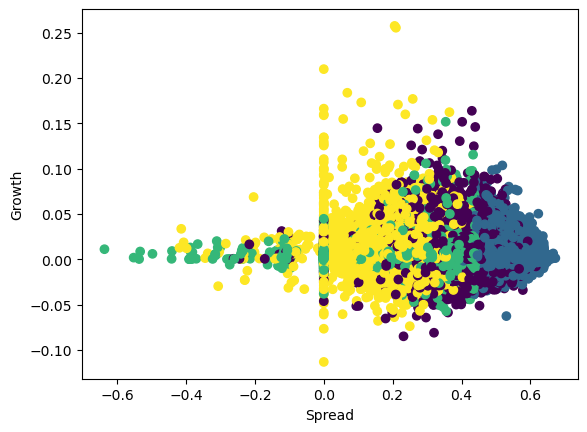

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



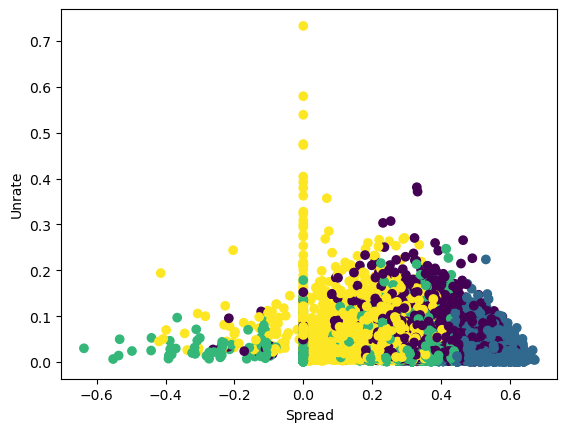

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



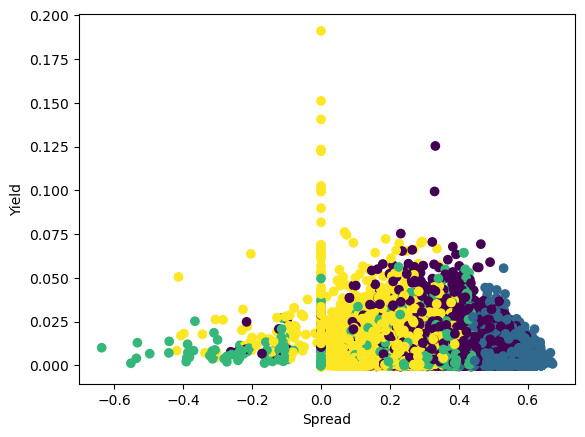

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



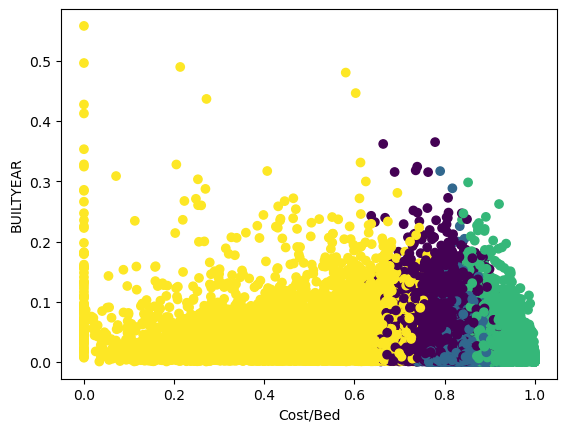

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



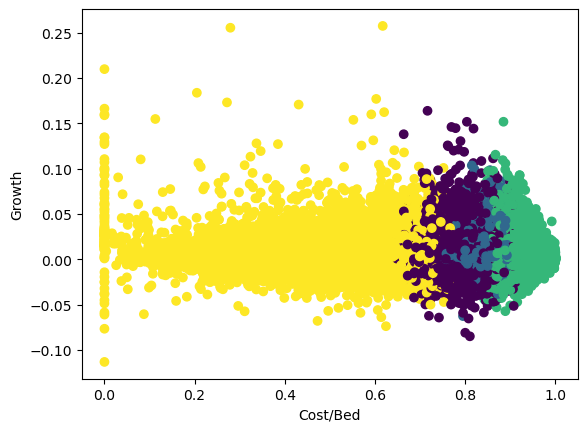

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



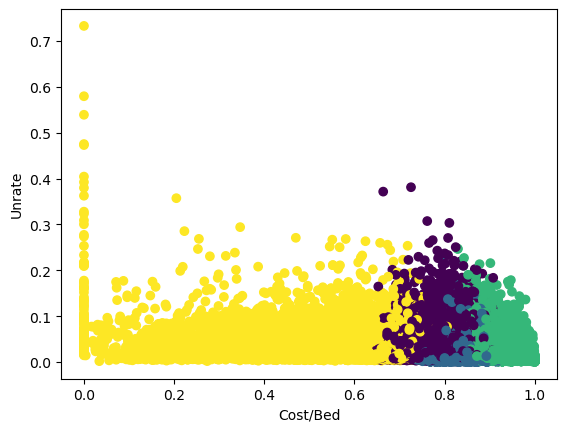

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



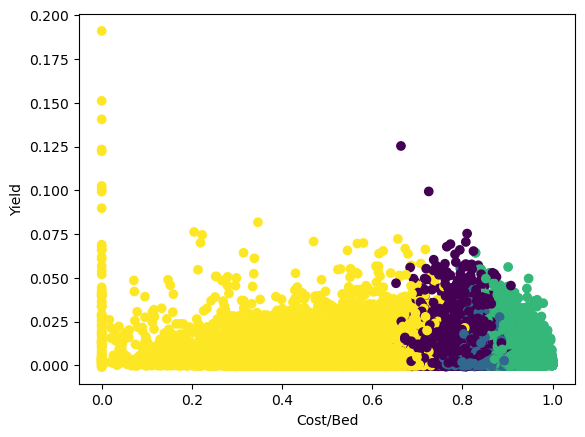

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



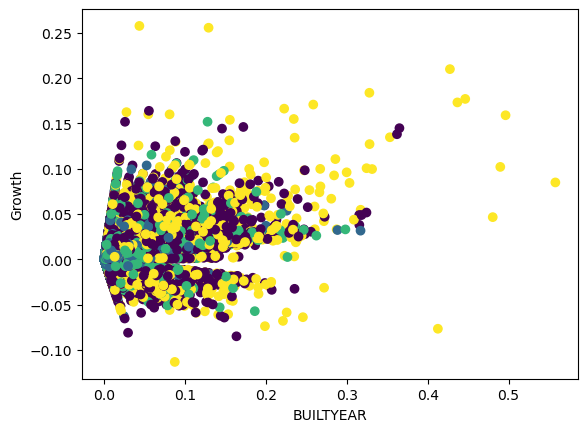

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



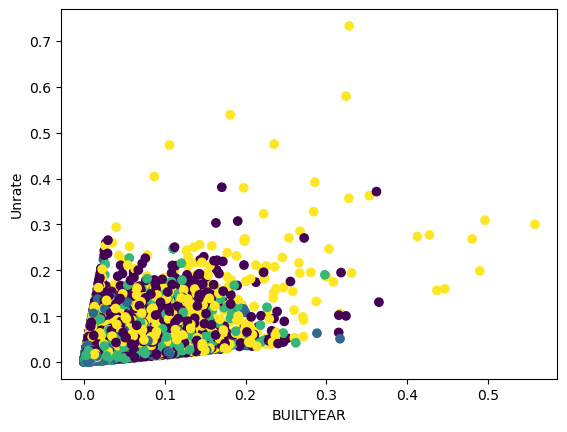

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



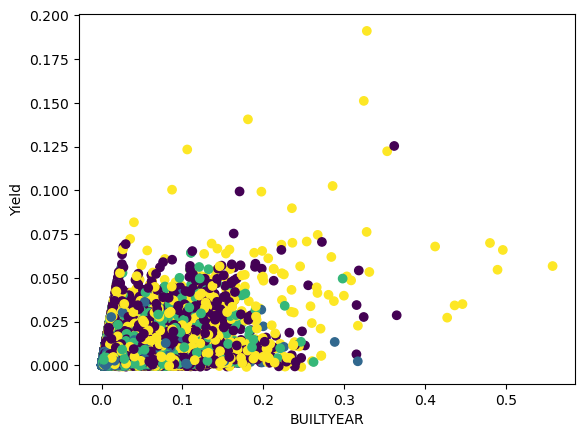

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



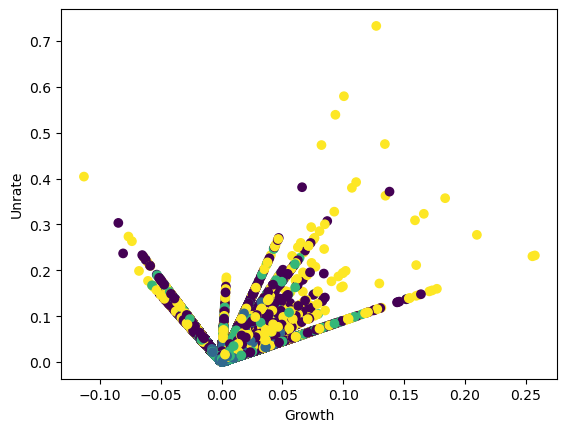

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



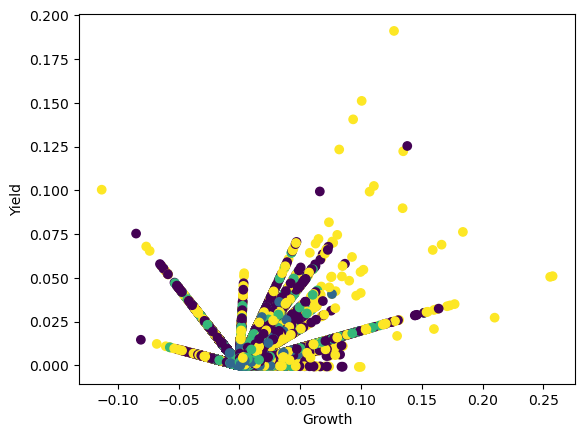

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



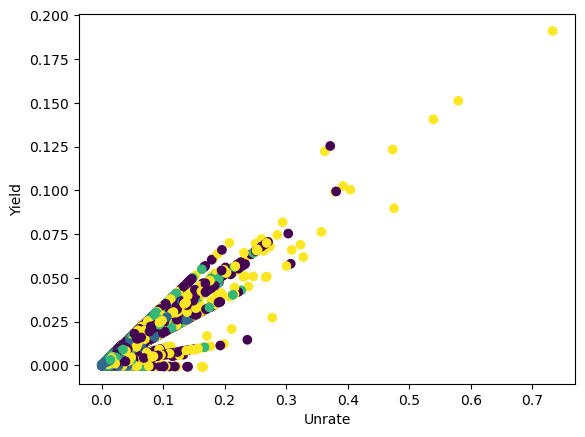

/Users/joanne/Desktop/ECON1680/Project1/4kmeansnorm.pdf


In [267]:
kmean(dfK,4,fPath,'4kmeansnorm')